/GPUFS/sysu_lhong_1/.conda/envs/pytorchgpu/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(32000, 3)
(20, 3) (20, 1)
epoch 0, gradient: 1.28081e+02, loss: 1.81889e+02, loss_u: 9.59088e-02, loss_f: 1.37655e+01, loss_0: 2.71906e+01, loss_c: 4.08728e-01, loss_c0: 9.99643e-01, mse: 4.57118e+01, loss_r: 4.08723e-01, loss_u0: 9.99649e-01
epoch 100, gradient: 5.50978e+00, loss: 1.30653e+02, loss_u: 7.22391e-02, loss_f: 4.07798e-01, loss_0: 3.15023e+01, loss_c: 2.48390e-02, loss_c0: 9.61865e-01, mse: 5.20507e+01, loss_r: 2.35721e-02, loss_u0: 9.63132e-01
epoch 200, gradient: 6.85247e+00, loss: 1.27289e+02, loss_u: 1.05271e-01, loss_f: 7.41840e-01, loss_0: 3.06045e+01, loss_c: 3.96610e-02, loss_c0: 9.18711e-01, mse: 5.13855e+01, loss_r: 2.25010e-02, loss_u0: 9.35871e-01
epoch 300, gradient: 7.80685e+00, loss: 1.22497e+02, loss_u: 1.25101e-01, loss_f: 1.95608e+00, loss_0: 2.83584e+01, loss_c: 6.73488e-02, loss_c0: 8.53225e-01, mse: 5.05551e+01, loss_r: 2.05716e-02, loss_u0: 9.00003e-01
epoch 400, gradient: 6.88404e+00, loss: 1.20470e+02, loss_u: 1.35546e-01, loss_f: 2.72389e+00, loss

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


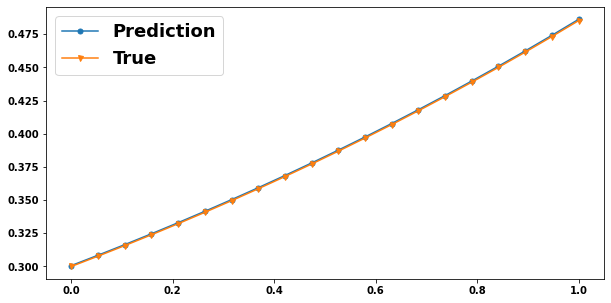

/GPUFS/sysu_lhong_1/Data/lgj/PPINNs/Logistci_ODE/PINNs_Params/PPINNs_Params.py:327: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


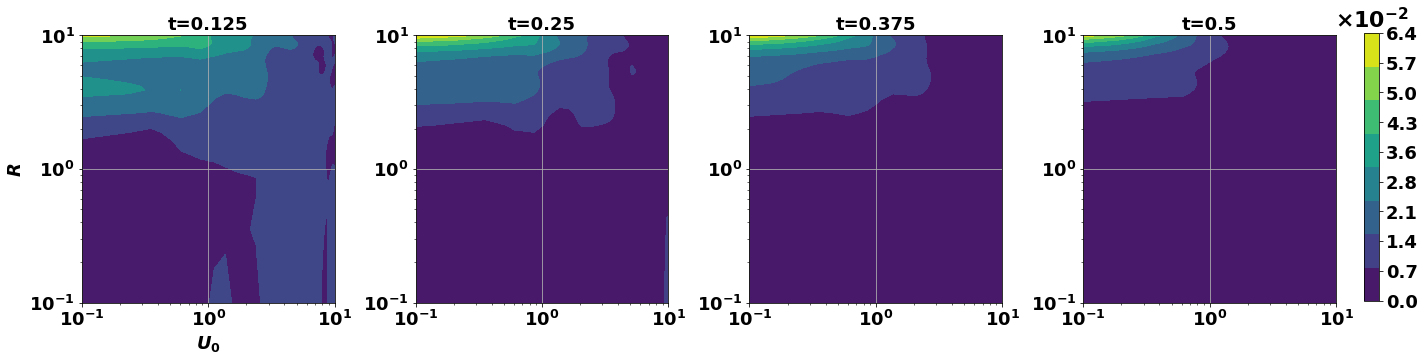

/GPUFS/sysu_lhong_1/Data/lgj/PPINNs/Logistci_ODE/PINNs_Params/PPINNs_Params.py:353: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


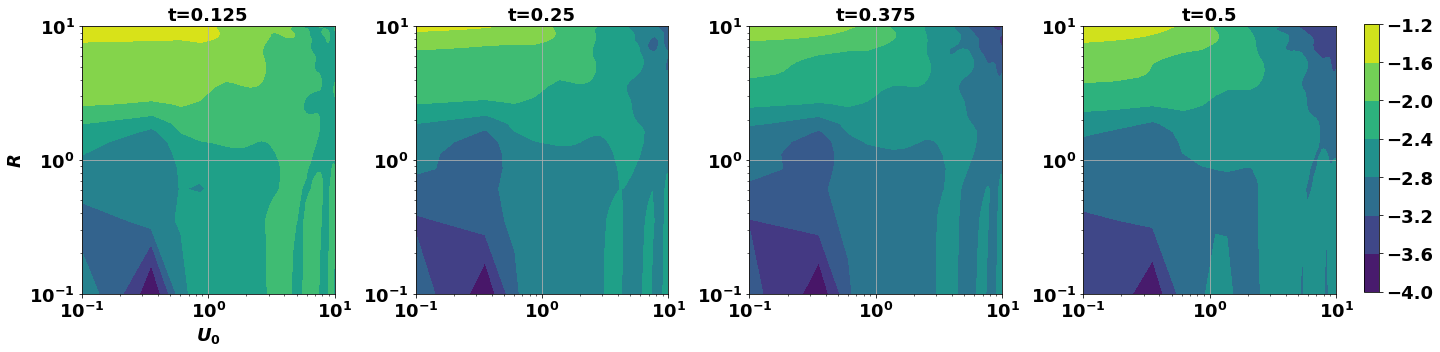

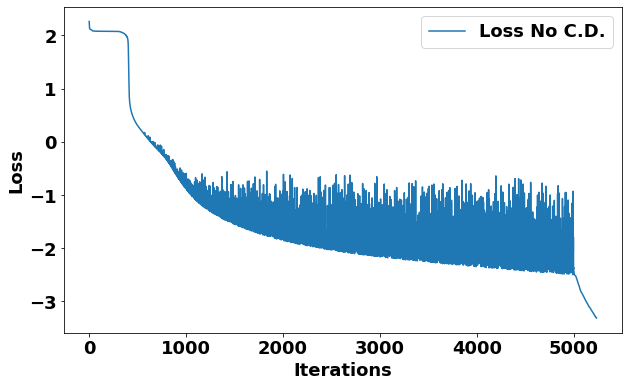

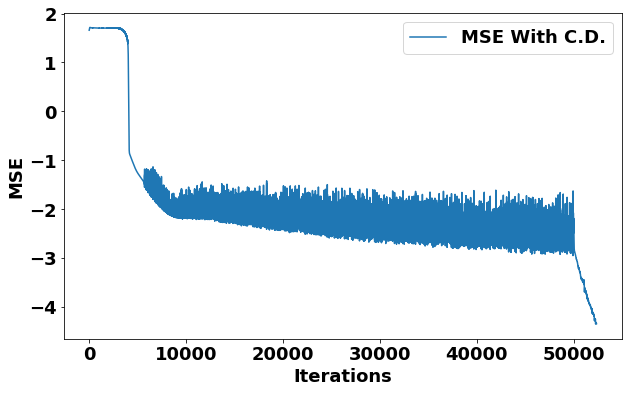

Total time :2751.178553342819 s


In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from utils import set_seed, FCNN
import time
from choose_optimizer import choose_optimizer
import skopt
from torch.optim.lr_scheduler import StepLR

class cd_PINN(torch.nn.Module):
    def __init__(self, X_u_train, u_train, X_f_train, layers, lr, optimizer_name, iterations, X_test, U_test):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Setting gradients
        self.x_u = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(self.device)
        self.y_u = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(self.device)
        self.t_u = torch.tensor(X_u_train[:, 2:3], requires_grad=True).float().to(self.device)
        self.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(self.device)
        self.y_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(self.device)
        self.t_f = torch.tensor(X_f_train[:, 2:3], requires_grad=True).float().to(self.device)
        self.t_0 = torch.tensor(np.zeros_like(X_f_train[:, 2:3]), requires_grad=True).float().to(self.device)
        self.u = torch.tensor(u_train, requires_grad=True).float().to(self.device)
        self.X_test = X_test
        self.U_test = U_test
        # Define basic net
        self.net = FCNN(layers)
        self.net.to(self.device)
        self.k = 10.0
        # Define the optimizers
        self.optimizer = choose_optimizer(optimizer_name, self.net.parameters(), lr)
        self.optimizer1 = choose_optimizer('LBFGS', self.net.parameters())
        self.iterations = iterations
        self.scheduler = StepLR(self.optimizer, step_size=5000, gamma=0.7)
        self.iter = 0
        self.loss, self.loss_u, self.loss_f, self.loss_0, self.loss_c, self.loss_c0, self.mse, self.loss_r, self.loss_u0 = [], [], [], [], [], [], [], [], []


    def net_u(self, x, y, t):
        u = self.net(torch.cat([x, y, t], dim=1))
        return u


    def net_f(self, x, y, t):
        u = self.net_u(x, y, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        u_xt = torch.autograd.grad(
            u_x, t,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True,
        )[0]

        u_yt = torch.autograd.grad(
            u_y, t,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True,
            retain_graph=True,
        )[0]

        f1 = u_t - y * u * (1 - u / self.k)
        f2 = u_yt - u * (1 - u / self.k) - y * u_y * (1 - 2 * u / self.k)
        f3 = u_xt - y * u_x * (1 - 2 * u / self.k)

        return f1, f2, f3

    def net_u0(self, x, y, t):
        u = self.net_u(x, y, t)

        u0 = u - x
        return u0

    def net_c0(self, x, y, t):
        u = self.net_u(x, y, t)

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        return u_x-1, u_y

    def loss_pinn(self, verbose=True):
        if torch.is_grad_enabled():
            self.optimizer.zero_grad()
            self.optimizer1.zero_grad()
        u_pred = self.net_u(self.x_u, self.y_u, self.t_u)
        f1, f2, f3 = self.net_f(self.x_f, self.y_f, self.t_f)
        u0 = self.net_u0(self.x_f, self.y_f, self.t_0)
        u_x, u_y = self.net_c0(self.x_f, self.y_f, self.t_0)

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f1 ** 2)
        loss_u0 = torch.mean(f3 ** 2) + torch.mean(u_x ** 2)
        loss_r = torch.mean(f2 ** 2) + torch.mean(u_y ** 2)
        loss_c = torch.mean(f2 ** 2) + torch.mean(f3 ** 2)
        loss_0 = torch.mean(u0 ** 2)
        loss_c0 = torch.mean(u_x ** 2) + torch.mean(u_y ** 2)

        loss = loss_u + loss_f + loss_0 + 1e2*(loss_c + loss_c0)

        if loss.requires_grad:
            loss.backward()

        grad_norm = 0
        for p in self.net.parameters():
            param_norm = p.grad.detach().data.norm(2)
            grad_norm += param_norm.item() ** 2
        grad_norm = grad_norm ** 0.5

        if verbose:
            u_test_pred, _, _ = model.predict(self.X_test)
            mse = np.mean((u_test_pred.reshape(-1, 1) - self.U_test.reshape(-1, 1)) ** 2)
            if self.iter % 100 == 0:
                print(
                    'epoch %d, gradient: %.5e, loss: %.5e, loss_u: %.5e, loss_f: %.5e, loss_0: %.5e, loss_c: %.5e, loss_c0: %.5e, mse: %.5e, loss_r: %.5e, loss_u0: %.5e' % (
                        self.iter, grad_norm, loss.item(), loss_u.item(), loss_f.item(), loss_0.item(), loss_c.item(), loss_c0.item(), mse, loss_r.item(), loss_u0.item())
                )
            self.iter += 1
            self.mse.append(mse)
            self.loss.append(loss.cpu().detach().item())
            self.loss_f.append(loss_f.cpu().detach().item())
            self.loss_0.append(loss_0.cpu().detach().item())
            self.loss_u.append(loss_u.cpu().detach().item())
            self.loss_c.append(loss_c.cpu().detach().item())
            self.loss_c0.append(loss_c0.cpu().detach().item())
            self.loss_r.append(loss_r.cpu().detach().item())
            self.loss_u0.append(loss_u0.cpu().detach().item())

        return loss

    def train(self):
        self.net.train()
        for i in range(self.iterations):
            self.optimizer.step(self.loss_pinn)
        print("The training process using adam is finished!")
        self.optimizer1.step(self.loss_pinn)

        return self.loss, self.loss_u, self.loss_f, self.loss_0, self.loss_c, self.loss_c0, self.mse, self.loss_r, self.loss_u0

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(self.device)

        self.net.eval()
        u = self.net_u(x, y, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]
        u_y = torch.autograd.grad(
            u, y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        u = u.detach().cpu().numpy()
        u_x = u_x.detach().cpu().numpy()
        u_y = u_y.detach().cpu().numpy()

        return u, u_x, u_y


if __name__ == '__main__':
    # cuda
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Random seed
    set_seed(0)
    # Training epoch of Adam
    iterations = 50000
    # Residual points
    N_f = 8192 * 2
    lb = np.array([0.1, 0.1, 0.0])
    ub = np.array([10.0, 10.0, 1.0])
    t_eval = np.linspace(0, 1, 20).reshape(-1, 1)
    xs = np.linspace(0.1, 10, 40).reshape(-1, 1)
    rs = np.linspace(0.1, 10, 40).reshape(-1, 1)
    #  Optimizer
    optimizer_name = 'Adam'
    lr = 0.0001
    # Test data
    path = r'Logistic_Grouth_Model/Data'
    file_train = r'/training_data_test.npz'
    file_test = r'/testing_data_test.npz'
    data_test = np.load(path + file_test)
    data_train = np.load(path + file_train)
    X_train, U_train = data_train['arr1'], data_train['arr2']
    X_test, U_test = data_test['arr1'], data_test['arr2']
    print(X_test.shape)
    # Train data
    space = [(lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2])]
    sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
    X_f_train = np.array(sampler.generate(space, N_f))
    X_u_train = np.array(X_train[::1])
    u_train = np.array(U_train[::1])
    print(X_u_train.shape, u_train.shape)
    # Network layer
    layers = [3, 128, 128, 128, 128, 128, 128, 1]
    # Model
    model = cd_PINN(X_u_train, u_train, X_f_train, layers, lr, optimizer_name, iterations, X_test, U_test)
    # Training
    start_time = time.time()
    loss, loss_u, loss_f, loss_0, loss_c, loss_c0, mse, loss_r, loss_u0 = model.train()
    end_time = time.time()
    # Saved the model and loss
    torch.save(model.state_dict(), path + r'/cd_PINN.pth')
    np.savez(path+r'/cd_PINN_loss.npz', arr1=loss, arr2=loss_u, arr3=loss_f, arr4=loss_0, arr5=loss_c, arr6=loss_c0, arr7=mse, arr8=loss_r, arr9=loss_u0)
    print('模型已保存/加载！')

    # Predict
    u_train_pred, _, _ = model.predict(X_train)
    u_test_pred, _, _ = model.predict(X_test)

    # Error
    error_u_NRMSE = np.linalg.norm(u_train_pred - u_train, 2) / np.linalg.norm(u_train.reshape(-1, 1), 2)
    error_u_NRMSE_test = np.linalg.norm(u_test_pred.reshape(-1, 1) - U_test.reshape(-1, 1), 2) / np.linalg.norm(
        U_test.reshape(-1, 1), 2)
    error_u_MAE = np.max(np.abs((u_train_pred - u_train)))
    error_u_MAE_test = np.max(np.abs(u_test_pred.reshape(-1, 1) - U_test.reshape(-1, 1)))
    error_u_MSE = np.mean((u_train_pred - u_train) ** 2)
    error_u_MSE_test = np.mean((u_test_pred.reshape(-1, 1) - U_test.reshape(-1, 1)) ** 2)
    error_u_NRMAE = np.mean(np.abs(u_train_pred - u_train)) / np.mean(np.abs(u_train))
    error_u_NRMAE_test = np.mean(np.abs(u_test_pred.reshape(-1, 1) - U_test.reshape(-1, 1))) / np.mean(
        np.abs(U_test.reshape(-1, 1)))
    print(
        f'Train Error u NRMSE: {error_u_NRMSE:.4e}, Test Error u NRMSE: {error_u_NRMSE_test:.4e}')
    print(
        f'Train Error u MAE: {error_u_MAE:.4e}, Test Error u MAE: {error_u_MAE_test:.4e}')
    print(
        f'Train Error u MSE: {error_u_MSE:.4e}, Test Error u MSE: {error_u_MSE_test:.4e}')
    print(
        f'Train Error u NRMAE: {error_u_NRMAE:.4e}, Test Error u NRMAE: {error_u_NRMAE_test:.4e}')

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.weight'] = 'bold'

    fig = plt.figure(figsize=(10, 5))
    plt.plot(t_eval, u_train_pred, marker='o', markersize=5, label='Prediction')
    plt.plot(t_eval, U_train, marker='v', markersize=5, label='True')
    plt.legend(fontsize=18)
    plt.show()
    plt.close()

    u_test_pred = u_test_pred.reshape(U_test.shape[0], U_test.shape[1], -1)

    time_points = [0.125, 0.25, 0.375, 0.5]
    fig1, axes = plt.subplots(1, 4, figsize=(20, 5))
    for t_idx, t in enumerate(time_points):
        t_index = np.argmin(np.abs((t_eval - t)))

        u_values = np.abs(u_test_pred[:, :, t_index] - U_test[:, :, t_index])

        ax = axes[t_idx]
        contour = ax.contourf(xs.squeeze(), rs.squeeze(), u_values, cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')
        if t_idx == 0:
            ax.set_xlabel('$U_0$', fontsize=18, fontweight='bold')
            ax.set_ylabel('$R$', fontsize=18, fontweight='bold')
        ax.set_title(f't={t}', fontsize=18, fontweight='bold')
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)

    cbar_ax = fig1.add_axes([0.95, 0.178, 0.01, 0.743])
    cbar = fig1.colorbar(contour, cax=cbar_ax)

    exponent = np.floor(np.log10(np.abs(cbar.vmax)))

    cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, num=10))
    cbar.set_ticklabels([f'{x / 10 ** exponent:.1f}' for x in cbar.get_ticks()])

    cbar.ax.set_title(f'$\\times 10^{{{int(exponent)}}}$', fontsize=22, fontweight='bold', pad=5)
    cbar.ax.tick_params(labelsize=18)

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

    time_points = [0.125, 0.25, 0.375, 0.5]
    fig1, axes = plt.subplots(1, 4, figsize=(20, 5))
    for t_idx, t in enumerate(time_points):
        t_index = np.argmin(np.abs((t_eval - t)))

        u_values = np.log10(np.abs(u_test_pred[:, :, t_index] - U_test[:, :, t_index]))

        ax = axes[t_idx]
        contour = ax.contourf(xs.squeeze(), rs.squeeze(), u_values, cmap='viridis')

        ax.set_xscale('log')
        ax.set_yscale('log')
        if t_idx == 0:
            ax.set_xlabel('$U_0$', fontsize=18, fontweight='bold')
            ax.set_ylabel('$R$', fontsize=18, fontweight='bold')
        ax.set_title(f't={t}', fontsize=18, fontweight='bold')
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)

    cbar_ax = fig1.add_axes([0.95, 0.178, 0.01, 0.743])
    cbar = fig1.colorbar(contour, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=18)
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

    data_loss_Params = np.load(path + r'/cd_PINN_loss.npz')
    loss_Params = data_loss_Params['arr1']
    loss_Params = np.log10(loss_Params)
    fig2 = plt.figure(figsize=(10, 6))
    plt.plot(loss_Params[::10], label='Loss No C.D.')
    plt.xlabel('Iterations', fontsize=18, fontweight='bold')
    plt.ylabel('Loss', fontsize=18, fontweight='bold')
    plt.legend(fontsize=18)
    plt.tick_params(labelsize=18)
    plt.legend(fontsize=18)
    plt.show()
    plt.close()

    mse_log = np.log10(mse)
    fig2 = plt.figure(figsize=(10, 6))
    plt.plot(mse_log[::1], label='MSE With C.D.')
    plt.xlabel('Iterations', fontsize=18, fontweight='bold')
    plt.ylabel('MSE', fontsize=18, fontweight='bold')
    plt.legend(fontsize=18)
    plt.tick_params(labelsize=18)
    plt.legend(fontsize=18)
    plt.show()
    plt.close()

    time_used = end_time-start_time
    print(f'Total time :{time_used} s')